In [1]:
import numpy as np
import pandas as pd

In [2]:
# Imports

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dropout, LeakyReLU, BatchNormalization, Input, Concatenate, Activation, concatenate
from keras.initializers import RandomNormal
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
import cv2
import PIL
from PIL import Image
import random
import h5py
import plotly.graph_objects as go  

In [3]:
# Loading the data which is preloaded as .npy files (numpy files) in order to make pre-processing easier 
gray_scale_images = np.load('archive/l/gray_scale.npy') 
ab1_images = np.load("archive/ab/ab/ab1.npy")
ab2_images = np.load('archive/ab/ab/ab2.npy')
ab3_images = np.load('archive/ab/ab/ab3.npy')


In [4]:
gray_scale_images

array([[[237, 135,  75, ...,  35,  37,  63],
        [234, 152,  72, ...,  41,  49,  47],
        [215, 216, 104, ...,  73,  48,  82],
        ...,
        [ 40,  45,  38, ...,  11,   8,   8],
        [ 40,  56,  47, ...,   8,   7,  10],
        [ 42,  60,  79, ...,  12,  13,  15]],

       [[202, 204, 207, ..., 133, 136, 138],
        [199, 199, 200, ..., 123, 128, 134],
        [196, 159, 153, ..., 110,  76, 131],
        ...,
        [222, 200, 194, ...,  98, 108, 166],
        [224, 224, 224, ..., 165, 166, 165],
        [224, 227, 227, ..., 170, 168, 167]],

       [[ 37,  37,  40, ..., 218, 218, 218],
        [ 36,  38,  40, ..., 217, 217, 217],
        [ 38,  39,  40, ..., 217, 217, 217],
        ...,
        [ 13,  56, 144, ..., 220, 221, 216],
        [ 12,  27, 145, ..., 226, 228, 238],
        [ 14,  18,  83, ..., 220, 212, 233]],

       ...,

       [[ 13,  33,  32, ...,  26,  33,  12],
        [ 62, 183, 180, ..., 155, 189,  65],
        [ 73, 199, 195, ..., 209, 219,  78

In [5]:
len(ab1_images)

10000

In [6]:
# In using Kaggle Kernels, I only have access to 16gbs of ram - which only supports roughly a maximum of 3000 images
# If I could train on more of the data, the results would've been far more accurate and precise
Xtrain = gray_scale_images[:3000]
Ytrain = ab1_images[:3000]

# The generalized model, ImageNet requires images to be a certain shape, as such we need to convert the shape from (224, 224, 1) to (224, 224, 3) using numpy
Xtrain = np.repeat(Xtrain[..., np.newaxis], 3, -1)

# # By subtracting and subsequently dividing by 127.5, we are normalizing the data in the range [-1, 1]. 
# These images would otherwise be in the range [0, 1], since we are working with LAB, this technique of normalizing works better
Xtrain = (Xtrain.astype('float32') - 127.5) / 127.5
Ytrain = (Ytrain.astype('float32') - 127.5) / 127.5

In [7]:
Xtrain

array([[[[ 0.85882354,  0.85882354,  0.85882354],
         [ 0.05882353,  0.05882353,  0.05882353],
         [-0.4117647 , -0.4117647 , -0.4117647 ],
         ...,
         [-0.7254902 , -0.7254902 , -0.7254902 ],
         [-0.70980394, -0.70980394, -0.70980394],
         [-0.5058824 , -0.5058824 , -0.5058824 ]],

        [[ 0.8352941 ,  0.8352941 ,  0.8352941 ],
         [ 0.19215687,  0.19215687,  0.19215687],
         [-0.43529412, -0.43529412, -0.43529412],
         ...,
         [-0.6784314 , -0.6784314 , -0.6784314 ],
         [-0.6156863 , -0.6156863 , -0.6156863 ],
         [-0.6313726 , -0.6313726 , -0.6313726 ]],

        [[ 0.6862745 ,  0.6862745 ,  0.6862745 ],
         [ 0.69411767,  0.69411767,  0.69411767],
         [-0.18431373, -0.18431373, -0.18431373],
         ...,
         [-0.42745098, -0.42745098, -0.42745098],
         [-0.62352943, -0.62352943, -0.62352943],
         [-0.35686275, -0.35686275, -0.35686275]],

        ...,

        [[-0.6862745 , -0.6862745 , -0

In [8]:

# Source: https://github.com/emilwallner/Coloring-greyscale-images/blob/master/Full-version/full_version.ipynb

# This project uses a transfer learning model that is generalized on a wide range of images
# Below is the model architecture which has taken partially from the above links due to my lack of experience with such models

# Importing the transfer learning model and preparing the kernel initializer values to initialise the weights and distribute them 
from tensorflow.keras.applications import MobileNetV2
weight_init = RandomNormal(stddev=0.02) 

# Preparing the Input layer
input_layer = Input((224, 224, 3))

# Downloading mobile net  trained on the imagenet dataset containing 1.4 million images and using it as the base of the model
# In using this model, we utilize its weights, but do not use its connected Dense Layer (#include_top=False), and instead build our own layer  atop the model
pre_trained_model = MobileNetV2(
    input_shape= (224, 224, 3),
    include_top=False, 
    weights='imagenet'
)
mobilenet = pre_trained_model(input_layer)


# Source: https://github.com/emilwallner/Coloring-greyscale-images/blob/master/Full-version/full_version.ipynb
# Defining the model architecture, (decoders and encoders)
# Encoder
# 224x224
conv1 = Conv2D(64, (3, 3), strides=(2, 2), padding='same', kernel_initializer=weight_init)(input_layer)
conv1 = LeakyReLU(alpha=0.2)(conv1)

# 112x112
conv2 = Conv2D(128, (3, 3), strides=(1, 1), padding='same', kernel_initializer=weight_init)(conv1)
conv2 = LeakyReLU(alpha=0.2)(conv2)

# 112x112
conv3 = Conv2D(128, (3, 3), strides=(2, 2), padding='same', kernel_initializer=weight_init)(conv2)
conv3 =  Activation('relu')(conv3)

# 56x56
conv4 = Conv2D(256, (3, 3), strides=(2, 2), padding='same', kernel_initializer=weight_init)(conv3)
conv4 = Activation('relu')(conv4)

# 28x28
conv4_ = Conv2D(256, (3, 3), strides=(1, 1), padding='same', kernel_initializer=weight_init)(conv4)
conv4_ = Activation('relu')(conv4_)

# 28x28
conv5 = Conv2D(512, (3, 3), strides=(2, 2), padding='same', kernel_initializer=weight_init)(conv4_)
conv5 = Activation('relu')(conv5)

# 14x14
conv5_ = Conv2D(256, (3, 3), strides=(2, 2), padding='same', kernel_initializer=weight_init)(conv5)
conv5_ = Activation('relu')(conv5_)

#7x7
# Fusion layer - Connects MobileNet with our encoder
conc = concatenate([mobilenet, conv5_])
fusion = Conv2D(512, (1, 1), padding='same', kernel_initializer=weight_init)(conc)
fusion = Activation('relu')(fusion)

# Skip fusion layer
skip_fusion = concatenate([fusion, conv5_])

# Decoder 
# 7x7
decoder = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', kernel_initializer=weight_init)(skip_fusion)
decoder = Activation('relu')(decoder)
decoder = Dropout(0.25)(decoder)

# Skip layer from conv5 (with added dropout)
skip_4_drop = Dropout(0.25)(conv5) # Drops 1/4 of the neurons to prevent overfitting 
skip_4 = concatenate([decoder, skip_4_drop])

# 14x14
decoder = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', kernel_initializer=weight_init)(skip_4)
decoder = Activation('relu')(decoder)
decoder = Dropout(0.25)(decoder)

# Skip layer from conv4_ (with added dropout)
skip_3_drop = Dropout(0.25)(conv4_)
skip_3 = concatenate([decoder, skip_3_drop])

# 28x28
decoder = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', kernel_initializer=weight_init)(skip_3)
decoder = Activation('relu')(decoder)
decoder = Dropout(0.25)(decoder)

# 56x56
decoder = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', kernel_initializer=weight_init)(decoder)
decoder = Activation('relu')(decoder)
decoder = Dropout(0.25)(decoder)

# 112x112
decoder = Conv2DTranspose(64, (3, 3), strides=(1, 1), padding='same', kernel_initializer=weight_init)(decoder)
decoder = Activation('relu')(decoder)

# 112x112
decoder = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', kernel_initializer=weight_init)(decoder)
decoder = Activation('relu')(decoder)

# 224x224
# Ooutput layer, with 2 channels (a and b)
output_layer = Conv2D(2, (1, 1), activation='tanh')(decoder)

model = Model(input_layer, output_layer)
model.compile(Adam(lr=0.0002), loss='mse', metrics=['accuracy'])

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-08-18 18:08:55.623083: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-18 18:08:55.623294: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/hamadsultan/miniforge3/envs/env_tensorflow/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 112, 112, 64  0           ['conv2d[0][0]']                 
                                )                                                             

In [10]:
model.load_weights('saved_model_weights.h5')

In [11]:
from keras.preprocessing import image
path = 'Before.png'

img = image.load_img(path, target_size=(224, 224, 1), color_mode = 'grayscale')
x = image.img_to_array(img)

In [12]:
x.shape

(224, 224, 1)

In [13]:
# Preprocessing the image in order to make inferences and predictions

# In order to meet the requirments for MobileNet, we need to convert the shape from (224, 224, 1) to (224, 224, 3)
x_l_repeated = np.repeat(x[..., np.newaxis], 3, -1) # To match the input shape, the L value is repeated
x_l_repeated = x_l_repeated.reshape((1, 224, 224, 3))

# Normalizing the input for prediction
x_l_repeated = (x_l_repeated.astype('float32') - 127.5) / 127.5

# Predicting the AB (color) compenents of LAB 
prediction = model.predict(x_l_repeated)

# Normalizing the output in a range between [-1, 1]
final_prediction = (prediction[0].astype('float32') * 127.5) + 127.5
grayscale_image = x.reshape((224, 224, 1))

2022-08-18 18:09:38.104279: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-18 18:09:38.315819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [14]:
# Combining the L (grayscale) image with the predicted AB component and combining them to form a colourized image
LAB_image = np.concatenate((x, final_prediction), axis=2)
LAB_image = LAB_image.astype("uint8")

# The cvtColor method is used to convert images from different colour spaces to another colour space using OpenCV
RGB_image = cv2.cvtColor(LAB_image, cv2.COLOR_LAB2RGB) 

# Converting the array back into an image with the RGB colour code
RGB_image = Image.fromarray(RGB_image)

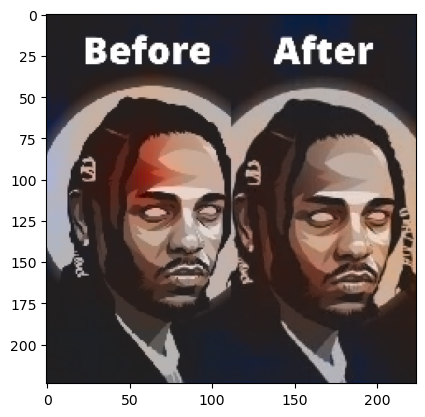

In [15]:
plt.imshow(RGB_image)